<h1><center><font color='red'><u> Image Captioning Project </center></font></u></h1>

<p style="right"> <font color='Purple'>Submitted by : <font color='Indigo'> Jitesh Kumar</u></font></p>

#####   

### ***Steps*** 
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference

In [11]:
#importing modules and libraries
import pandas as pd
import numpy as np
import tensorflow
import re
import json
from time import time
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

In [16]:
def read_text_file(path):
    with open(path) as f:
        captions = f.read()
    
    return captions

In [19]:
#Reading token file into captions
captions = read_text_file("https://drive.google.com/file/d/1l55lfyle8T7NPDPDQEbHrAtNIQCuQBXt/view?usp=sharing")

OSError: [Errno 22] Invalid argument: 'https://drive.google.com/file/d/1l55lfyle8T7NPDPDQEbHrAtNIQCuQBXt/view?usp=sharing'

In [5]:
captions

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainbow with her hands in 

In [6]:
#Data of type:
"""
IMid1\CPid1
IMid1\CPid2
.
.
IMid1\CPid5
IMid2\CPid1
IMid2\CPid2
.
.
IMid2\CPid5
.
"""
#Splitting different-different captions
captions = captions.split('\n')[:-1]

In [7]:
len(captions)

40460

In [8]:
#Seeing top 5 enteries
captions[0:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [9]:
#Just looking
first,second = captions[0].split('\t')
print(first, second)
img = first.split('.')[0]
print(img)

1000268201_693b08cb0e.jpg#0 A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e


In [10]:
descriptions ={}

for caption in captions:
    first, second = caption.split('\t')
    img_name = first.split('.')[0]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
                                  
    descriptions[img_name].append(second)

In [11]:
#Again just looking
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

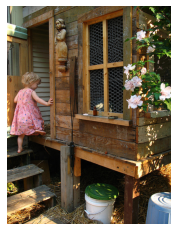

In [12]:
#Just Plotting and checking
import cv2
import matplotlib.pyplot as plt
IMG_PATH = "/content/drive/My Drive/Flickr_Data/Images/"
img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

#####  

### ***Data Cleaning***


In [13]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+", " ", sentence)
    
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)> 1]
    sentence = (" ").join(sentence)
    
    return sentence

In [14]:
clean_text("A boy is living at house #6.")

'boy is living at house'

In [15]:
for key, caption_list in descriptions.items():
    for i in range(len(caption_list)):
         caption_list[i] = clean_text(caption_list[i])

In [16]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [17]:
with open("D:\ML datasets\Flickr_Data\Flickr_TextData_worked\descriptions_cleaned.txt", "w") as f:
    f.write(str(descriptions))

#####  

### ***Setting up Vocabulary*** 

In [18]:
with open("/content/drive/My Drive/Flickr_Data/Flickr_TextData_worked/descriptions_cleaned.txt") as f:
    descriptions = f.read()
    descriptions = json.loads(descriptions.replace("'", "\""))

In [19]:
#seeing total no. of words
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for sentence in descriptions[key] for i in sentence.split()]

len(total_words)

373837

In [20]:
#seeing unique words in vocabulary
unique_words = set()
for key in descriptions.keys():
    [unique_words.update(sentence.split()) for sentence in descriptions[key]]

len(unique_words)

8424

In [21]:
import collections
counter = collections.Counter(total_words)
freq_count = dict(counter)
freq_count

{'child': 1545,
 'in': 18987,
 'pink': 739,
 'dress': 348,
 'is': 9345,
 'climbing': 507,
 'up': 1302,
 'set': 109,
 'of': 6723,
 'stairs': 109,
 'an': 2432,
 'entry': 1,
 'way': 53,
 'girl': 3328,
 'going': 149,
 'into': 1074,
 'wooden': 284,
 'building': 511,
 'little': 1768,
 'playhouse': 6,
 'the': 18420,
 'to': 3176,
 'her': 1178,
 'cabin': 4,
 'black': 3848,
 'dog': 8138,
 'and': 8863,
 'spotted': 38,
 'are': 3505,
 'fighting': 133,
 'tri': 14,
 'colored': 221,
 'playing': 2008,
 'with': 7765,
 'each': 430,
 'other': 773,
 'on': 10746,
 'road': 398,
 'white': 3959,
 'brown': 2578,
 'spots': 29,
 'staring': 57,
 'at': 2916,
 'street': 944,
 'two': 5643,
 'dogs': 2125,
 'different': 46,
 'breeds': 5,
 'looking': 744,
 'pavement': 48,
 'moving': 41,
 'toward': 146,
 'covered': 372,
 'paint': 62,
 'sits': 577,
 'front': 1386,
 'painted': 64,
 'rainbow': 22,
 'hands': 246,
 'bowl': 30,
 'sitting': 1368,
 'large': 1237,
 'small': 1278,
 'grass': 1622,
 'plays': 526,
 'fingerpaints': 3,

In [23]:
sorted_freq_count = sorted(freq_count.items(), reverse = True, key=lambda x:x[1])
threshold = 10
sorted_freq_count  = [x for x in sorted_freq_count if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_count]
sorted_freq_count

[('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2916),
 ('people', 2887),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('through', 2032),
 ('playing', 2008),
 ('while', 1968),
 ('shirt', 1962),
 ('down', 1843),
 ('standing', 1789),
 ('ball', 1783),
 ('little', 1768),
 ('grass', 1622),
 ('snow', 1547),
 ('child', 1545),
 ('person', 1542),
 ('jumping', 1473),
 ('over', 1415),
 ('three', 1389),
 ('front', 1386),
 ('sitting', 1368),
 ('holding', 1324),
 ('up', 1302),
 ('field', 1283),
 ('small', 1278),
 ('by', 1249),
 ('large', 1237),
 ('green', 1234),
 ('one', 1223),
 ('group', 1218),
 ('yellow', 1217),
 ('her', 1178),
 ('walk

In [24]:
vocab = [x[0] for x in sorted_freq_count if x[1] > 10]
vocab
len(vocab)

1845

#####  

### ***Prepare Train/Test Data***

In [25]:
train_text_file = read_text_file("/content/drive/My Drive/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_text_file = read_text_file("/content/drive/My Drive/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")
train_data = [x.split('.')[0] for x in train_text_file.split('\n')[:-1]]
test_data = [x.split('.')[0] for x in test_text_file.split('\n')[:-1]]

In [26]:
train_data[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [27]:
train_descriptions = {}

for img_id in train_data:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "<s> "+cap+" <e>"
        train_descriptions[img_id].append(cap_to_append)

In [28]:
train_descriptions["2513260012_03d33305cf"]

['<s> black dog is running after white dog in the snow <e>',
 '<s> black dog chasing brown dog through snow <e>',
 '<s> two dogs chase each other across the snowy ground <e>',
 '<s> two dogs play together in the snow <e>',
 '<s> two dogs running through low lying body of water <e>']

#####  

### ***Transfer Learning***

- Images --> Features
- Text ---> Features 

#### Step - 1 Image Feature Extraction


In [29]:
model = ResNet50(weights = "imagenet", input_shape=(224, 224, 3))
print(model.summary())

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [30]:
model_new = Model(model.input, model.layers[-2].output)

In [31]:
def preprocess_img(img):
  img = image.load_img(img, target_size = (224, 224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  img = preprocess_input(img)
  return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


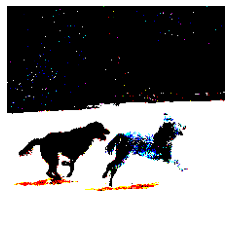

In [32]:
img = preprocess_img(IMG_PATH+"2513260012_03d33305cf.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [33]:
def encode_img(img):
  img = preprocess_img(img)
  feature_vector = model_new.predict(img)
  feature_vector = feature_vector.reshape((-1))
  return feature_vector

In [34]:
encode_img(IMG_PATH+"2513260012_03d33305cf"+".jpg")

array([0.34707952, 0.51159066, 0.08728839, ..., 1.1897292 , 0.04043854,
       0.15271072], dtype=float32)

In [35]:
"""start_time = time()
encoding_train = {}

for idx, img_id in enumerate(train_data):
  encoding_train[img_id] = encode_img(IMG_PATH+img_id+".jpg")
  if(idx%100 == 0):
    print(idx/100)

end_time = time()
print("Total time is: ", end_time - start_time)"""

'start_time = time()\nencoding_train = {}\n\nfor idx, img_id in enumerate(train_data):\n  encoding_train[img_id] = encode_img(IMG_PATH+img_id+".jpg")\n  if(idx%100 == 0):\n    print(idx/100)\n\nend_time = time()\nprint("Total time is: ", end_time - start_time)'

In [36]:
import pickle

In [37]:
"""with open("/content/drive/My Drive/Flickr_Data/encoded_train_features.pkl", "wb") as f:
  pickle.dump(encoding_train, f)"""

'with open("/content/drive/My Drive/Flickr_Data/encoded_train_features.pkl", "wb") as f:\n  pickle.dump(encoding_train, f)'

In [38]:
"""#Encoding test data
start_time = time()
encoding_test = {}

for idx, img_id in enumerate(test_data):
  encoding_test[img_id] = encode_img(IMG_PATH+img_id+".jpg")
  if(idx%100 == 0):
    print(idx/100)

end_time = time()
print("Total time is: ", end_time - start_time)"""

'#Encoding test data\nstart_time = time()\nencoding_test = {}\n\nfor idx, img_id in enumerate(test_data):\n  encoding_test[img_id] = encode_img(IMG_PATH+img_id+".jpg")\n  if(idx%100 == 0):\n    print(idx/100)\n\nend_time = time()\nprint("Total time is: ", end_time - start_time)'

In [39]:
!mkdir saved

In [40]:
"""with open("/content/drive/My Drive/Flickr_Data/encoded_test_features.pkl", "wb") as f:
  pickle.dump(encoding_test, f)"""

'with open("/content/drive/My Drive/Flickr_Data/encoded_test_features.pkl", "wb") as f:\n  pickle.dump(encoding_test, f)'

In [41]:
with open("/content/drive/My Drive/Flickr_Data/encoded_train_features.pkl", "rb") as f:
  encoding_train = pickle.load(f)

In [42]:
with open("/content/drive/My Drive/Flickr_Data/encoded_test_features.pkl", "rb") as f:
  encoding_test= pickle.load(f)

In [43]:
encoding_train

{'2513260012_03d33305cf': array([0.34707952, 0.51159066, 0.08728839, ..., 1.1897291 , 0.04043854,
        0.1527107 ], dtype=float32),
 '2903617548_d3e38d7f88': array([0.        , 0.00303404, 0.09360076, ..., 0.43107897, 0.37979543,
        0.9166433 ], dtype=float32),
 '3338291921_fe7ae0c8f8': array([0.7674462 , 0.5342263 , 0.38325197, ..., 0.02098641, 0.18429387,
        0.0427001 ], dtype=float32),
 '488416045_1c6d903fe0': array([6.2481064e-01, 3.2965466e-01, 1.7823005e-04, ..., 1.2753811e+00,
        4.6392554e-01, 4.9036065e-01], dtype=float32),
 '2644326817_8f45080b87': array([0.1155531 , 0.6596542 , 0.05323296, ..., 0.14397316, 1.017938  ,
        0.00556593], dtype=float32),
 '218342358_1755a9cce1': array([1.7061828 , 0.4051473 , 0.35206562, ..., 0.29408905, 0.04833037,
        0.04654422], dtype=float32),
 '2501968935_02f2cd8079': array([0.10608292, 1.4420801 , 0.04447012, ..., 0.20587148, 0.6978752 ,
        1.590432  ], dtype=float32),
 '2699342860_5288e203ea': array([0.4612

In [44]:
vocab[0:5]

['in', 'the', 'on', 'is', 'and']

#####  

### ***Data pre-processing for Captions***

In [45]:
len(vocab)

1845

In [46]:
word_to_idx = {}
idx_to_word = {}

for idx, word in enumerate(vocab):
  word_to_idx[word] = idx+1
  idx_to_word[idx+1] = word

print(word_to_idx["and"])
print(idx_to_word[5])

5
and


In [47]:
word_to_idx["<s>"] = len(vocab)+1
idx_to_word[len(vocab)+1] = "<s>"

word_to_idx["<e>"] = len(vocab)+2
idx_to_word[len(vocab)+2] = "<e>"

In [48]:
print(len(word_to_idx))
vocab_size = len(word_to_idx)+1
vocab_size

1847


1848

In [49]:
max_len = 0
for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
   max_len = max(max_len, len(cap.split()))

print(max_len)

35


#####  

### ***Data Loader (Generator)***

In [50]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
  X1, X2, Y = [],[],[]
  n = 0

  while True:
    for key, captions in train_descriptions.items():
      n+=1
      photo = encoding_train[key]
      
      for caption in captions:
        seq = [word_to_idx[word] for word in caption.split() if word in word_to_idx]

        for i in range(1, len(seq)):
          xi = seq[0:i]
          yi = seq[i]
          xi = pad_sequences([xi], value =0, maxlen= max_len, padding = 'post')[0]
          yi = to_categorical([yi], num_classes = vocab_size)[0]

          X1.append(photo)
          X2.append(xi)
          Y.append(yi)
        
        if(n==batch_size):
          yield [[np.array(X1),np.array(X2)],np.array(Y)]
          X1, X2, Y = [], [], []
          n=0

######  

### ***Word Embeddings*** 

In [51]:
f = open("/content/drive/My Drive/Flickr_Data/glove.6B.50d.txt", encoding = 'utf8')

In [52]:
embedding_index = {}

for line in f:
  values = line.split()
  word = values[0]

  word_embedding = np.array(values[1:],dtype='float')
  embedding_index[word] = word_embedding

In [53]:
f.close()

In [54]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [55]:
def get_embedding_matrix():
  emb_dim = 50
  matrix = np.zeros((vocab_size, emb_dim))

  for word,idx in word_to_idx.items():
    embedding = embedding_index.get(word)

    if embedding is not None:
      matrix[idx] = embedding
  
  return matrix

In [56]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

######  

### ***Model Architecture***

In [57]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(rate = 0.6)(input_img_features)
inp_img2 = Dense(256, activation ='relu')(inp_img1)

In [58]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(rate = 0.6)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [59]:
decoder_input = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation = 'relu')(decoder_input)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [input_img_features, input_captions], outputs = outputs)

In [60]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [61]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [62]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [63]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

#####  

### ***Training of Model***

In [64]:
epochs = 15
batch_size = 3
steps = len(train_descriptions)//batch_size

In [65]:
def train():
    
  for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save("/content/drive/My Drive/Flickr_Data/model_weights_trained/model_" + str(i) +".h5")

In [66]:
"""start_time = time()
train()
end_time = time()
print("Total time is: ", end_time - start_time)"""

'start_time = time()\ntrain()\nend_time = time()\nprint("Total time is: ", end_time - start_time)'

In [82]:
model = load_model('/content/drive/My Drive/Flickr_Data/model_weights_trained/model_cb.h5')
model2 = load_model('/content/drive/My Drive/Flickr_Data/model_weights_trained/model_9.h5')

#####  

### ***Predictions***

In [83]:
def predict_caption(photo):
    
    in_text = "<s>"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "<e>":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [84]:
def predict_caption2(photo):
    
    in_text = "<s>"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model2.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "<e>":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [85]:
def beam_search_pred(model, pic_fe, wordtoix, K_beams = 3, log = False):
    start_token = "<s>"
    start = [wordtoix[start_token]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_len).reshape((1,max_len)) #sequence of most probable words 
                                                                                         # based on the previous steps
            preds = model.predict([pic_fe.reshape(1,2048), sequence])
            word_preds = np.argsort(preds[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                         # K_beams items. words with the most probs
            # Getting the top <K_beams>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words4
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [idx_to_word[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != "<e>":
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [86]:
def beam_search_pred2(model2, pic_fe, wordtoix, K_beams = 3, log = False):
    start_token = "<s>"
    start = [wordtoix[start_token]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_len).reshape((1,max_len)) #sequence of most probable words 
                                                                                         # based on the previous steps
            preds = model2.predict([pic_fe.reshape(1,2048), sequence])
            word_preds = np.argsort(preds[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                         # K_beams items. words with the most probs
            # Getting the top <K_beams>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words4
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [idx_to_word[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != "<e>":
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

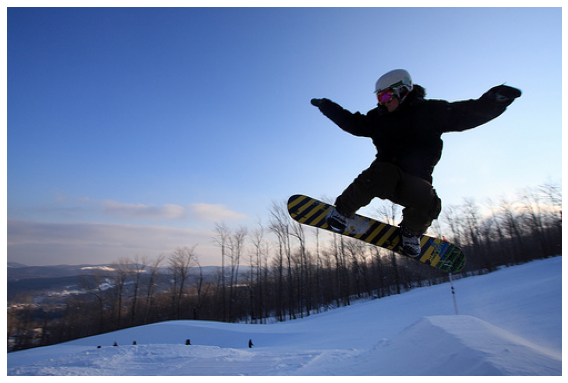

snowboarder in the air
snowboarder in the middle of the snow
snowboarder is jumping over ramp
man in green shirt is snowboarding in the air


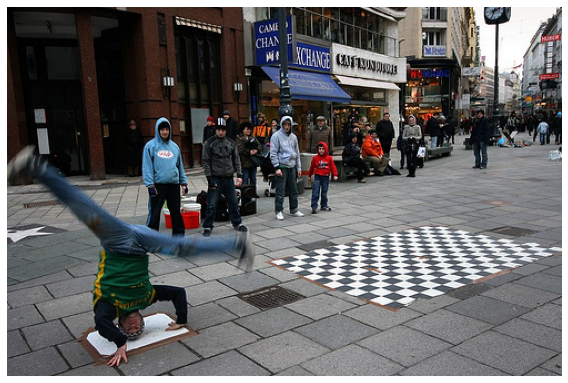

people are standing in front of an ice cream
group of people are standing in front of some
man in red shirt is walking on the street
group of people are standing in front of large building


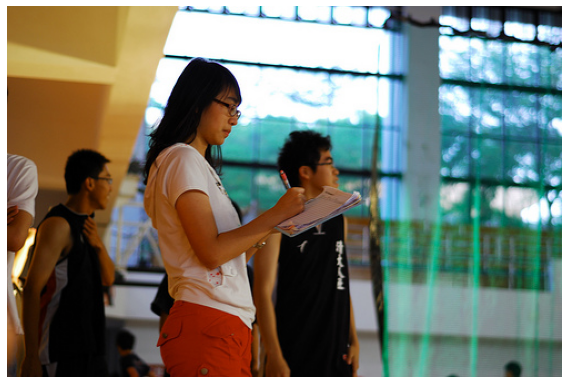

man in blue shirt and black shirt is standing in front of crowd
group of people are standing in front of crowd
woman in red shirt and white shirt is standing on the phone
woman in red shirt and white shirt is standing in front of brick wall


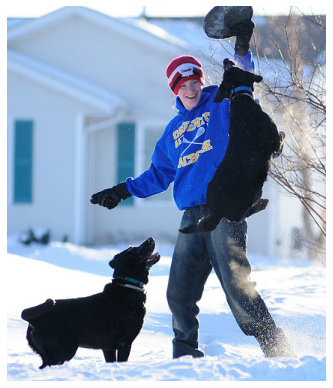

child in red coat is ice skating
the little boy in the red jacket is in the snow
child in red coat and red helmet is skating in the snow
child in red coat is skating in the snow


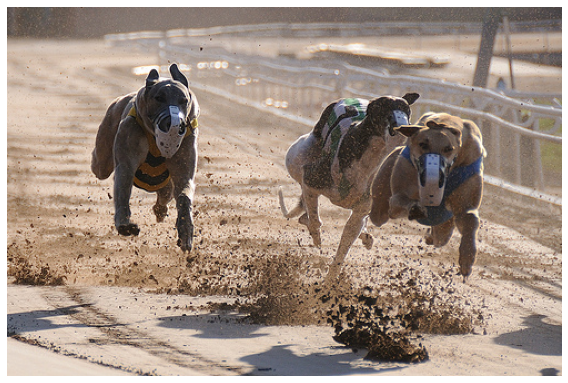

two dogs are running on the dry
two dogs are running in the dry
two dogs running on sandy track
two dogs are running on dirt track


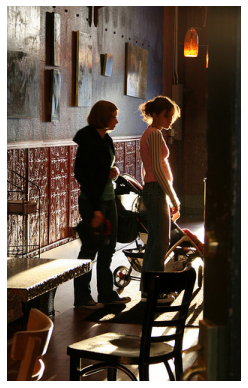

man and woman sit on bench
man and woman sit on bench in front of window
man in black shirt and jeans is sitting on bench
man and woman sit on bench in front of wooden wall


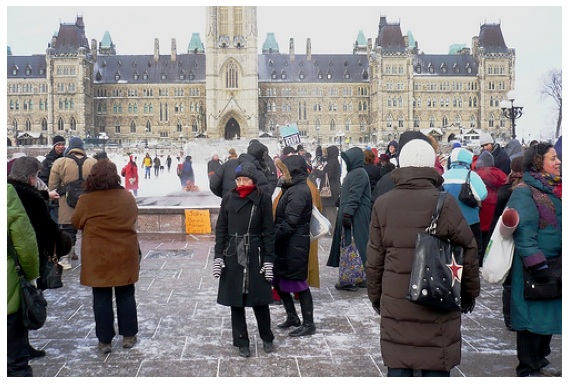

group of people stand in line of building
group of people stand in front of building
group of people are standing in front of large building
group of people are standing in front of large building


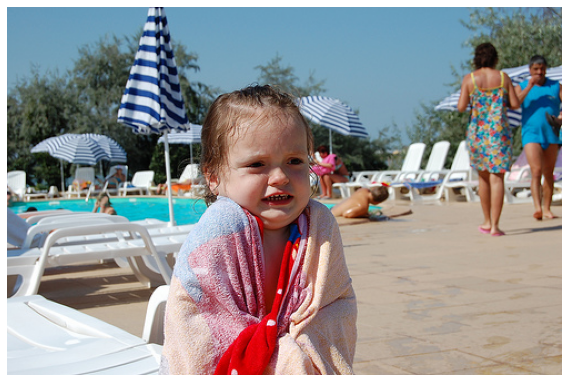

woman in black shirt and shorts is standing on the beach
woman in black shirt is standing in front of the ocean
young girl in pink shirt and pink shorts is standing on the sidewalk
little girl in pink bathing suit is standing in the sprinklers


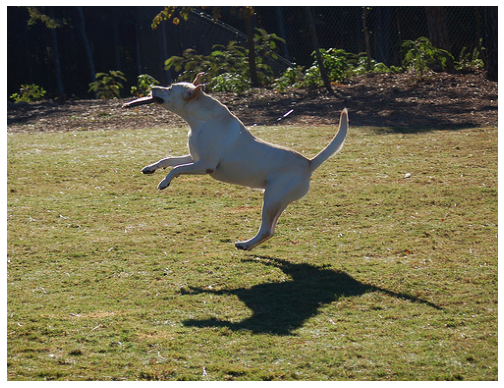

dog running in field of grass
two dogs are playing in the grass
dog jumps into the air to catch frisbee
brown dog jumping into the air to catch tennis ball in its mouth


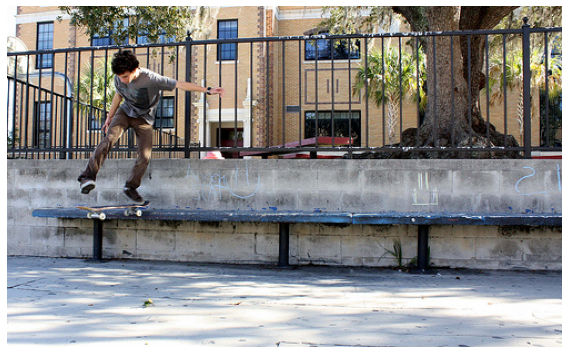

man in green shirt is walking on the sidewalk
boy in blue shirt is jumping off of cement wall in the air
man in black shirt is standing on bench near the steps
man in black shirt and jeans is standing on bench in front of brick wall


In [88]:
plt.style.use("seaborn")
for i in range(10):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread(IMG_PATH+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    caption2 = beam_search_pred(model, photo_2048, word_to_idx, K_beams = 3, log = True)
    caption3 = predict_caption2(photo_2048)
    caption4 = beam_search_pred2(model2, photo_2048, word_to_idx, K_beams = 3, log = True)
    #print(caption)

    
    
    fig = plt.figure()
    #plt.text(caption, y =-0.01)
    #fig.text(.5, .000005, caption, ha='center', fontsize = 16)

    #fig.text(.5, .000005, caption2, ha='center', fontsize = 16)
    plt.imshow(i)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    print(caption)
    print(caption2)
    print(caption3)
    print(caption4)
